# Velocity at Depth Levels

The goal of this notebook is the following:

1) serve as an example of how to post-process CESM/MOM6 output;

2) create time averages of Eulerian velocity fields at depth levels;

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6plot import xyplot
from mom6_tools.m6toolbox import cime_xmlquery
from mom6_tools import m6toolbox
import matplotlib.pyplot as plt
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
import yaml, intake, os
import numpy as np
import xarray as xr
from IPython.display import display, Markdown, Latex


ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/gmarques/conda-envs/mom6-tools/share/proj failed


Basemap module not found. Some regional plots may not function properly


In [3]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [4]:
caseroot = diag_config_yml['Case']['CASEROOT']
casename = cime_xmlquery(caseroot, 'CASE')
DOUT_S = cime_xmlquery(caseroot, 'DOUT_S')
rundir = cime_xmlquery(caseroot, 'RUNDIR')

if DOUT_S:
  OUTDIR = cime_xmlquery(caseroot, 'DOUT_S_ROOT')+'/ocn/hist/'
else:
  OUTDIR = cime_xmlquery(caseroot, 'RUNDIR')
    
print('Rundir directory is:', rundir)
print('Casename is:', casename)

Rundir directory is: /glade/derecho/scratch/gmarques/g.e30_a03c.GJRAv4.TL319_t232_wgx3_hycom1_N75.2024.079/run
Casename is: g.e30_a03c.GJRAv4.TL319_t232_wgx3_hycom1_N75.2024.079


In [5]:
# create an empty class object
class args:
  pass# create an empty class object
    
# load avg dates
avg = diag_config_yml['Avg']

args.start_date = avg['start_date']
args.end_date = avg['end_date']
args.casename = casename
args.monthly = casename+diag_config_yml['Fnames']['z']
args.geom =   casename+diag_config_yml['Fnames']['geom']
args.static = casename+diag_config_yml['Fnames']['static']
args.savefigs = False
args.nw = 6 # requesting 6 workers

In [6]:
# read grid info
geom_file = OUTDIR+'/'+args.geom
if os.path.exists(geom_file):
  grd = MOM6grid(OUTDIR+'/'+args.static, geom_file)
else:
  grd = MOM6grid(OUTDIR+'/'+args.static)

MOM6 grid successfully loaded... 



In [7]:
grd_xr = MOM6grid(OUTDIR+'/'+args.static, geom_file, xrformat=True)
grd_xr

MOM6 grid successfully loaded... 



<xarray.Dataset> Size: 29MB
Dimensions:       (xh: 540, yh: 480, time: 1, xq: 540, yq: 480)
Coordinates:
  * xh            (xh) float64 4kB -286.7 -286.0 -285.3 ... 71.33 72.0 72.67
  * yh            (yh) float64 4kB -81.56 -81.46 -81.36 ... 87.65 87.71 87.74
  * time          (time) float64 8B 0.0
  * xq            (xq) float64 4kB -286.3 -285.7 -285.0 ... 71.67 72.33 73.0
  * yq            (yq) float64 4kB -81.51 -81.41 -81.31 ... 87.68 87.73 87.74
Data variables: (12/24)
    geolon        (yh, xh) float64 2MB -286.7 -286.0 -285.3 ... 72.97 72.98 73.0
    geolat        (yh, xh) float64 2MB -81.56 -81.56 -81.56 ... 50.11 49.99
    geolon_c      (yq, xq) float64 2MB -286.3 -285.7 -285.0 ... 73.0 73.0 73.0
    geolat_c      (yq, xq) float64 2MB -81.51 -81.51 -81.51 ... 50.19 50.04 50.0
    geolon_u      (yh, xq) float32 1MB nan nan nan nan ... 72.98 72.99 73.0
    geolat_u      (yh, xq) float32 1MB ...
    ...            ...
    sin_rot       (yh, xh) float32 1MB ...
    cos_rot       (yh, xh) float32 1MB ...
    mgeolon       (yh, xh) float32 1MB nan nan nan nan ... 72.97 72.98 73.0
    mgeolon_c     (yh, xq) float32 1MB nan nan nan nan ... 72.98 72.99 73.0
    mgeolon_u     (yh, xq) float32 1MB nan nan nan nan ... 72.98 72.99 73.0
    mgeolon_v     (yh, xh) float32 1MB nan nan nan nan ... 72.97 72.98 73.0
Attributes:
    NumFilesInSet:  1
    title:          MOM6 diagnostic fields table for CESM case: g.e30_a03c.GJ...
    grid_type:      regular
    grid_tile:      N/A

In [8]:
parallel = False
if args.nw > 1:
  parallel = True
  cluster = NCARCluster()
  cluster.scale(args.nw)
  client = Client(cluster)

In [9]:
client

<Client: 'tcp://128.117.208.116:38657' processes=0 threads=0, memory=0 B>

In [10]:
# load history files

def preprocess(ds):
    ''' Return a dataset desired variables'''
    variables = ['uo', 'vo']
    return ds[variables]

ds = xr.open_mfdataset(OUTDIR+args.monthly, \
         parallel=True, data_vars='minimal', \
         coords='minimal', compat='override', preprocess=preprocess)

In [11]:
# Select data
%time ds_sel = ds.sel(time=slice(args.start_date, args.end_date))

CPU times: user 7.63 ms, sys: 60 μs, total: 7.69 ms
Wall time: 7.7 ms


In [12]:
# compute annual mean and then average in time
ds_ann = m6toolbox.weighted_temporal_mean_vars(ds_sel)

In [13]:
uo = np.ma.masked_invalid(ds_ann.uo.mean('time').values)
vo = np.ma.masked_invalid(ds_ann.vo.mean('time').values)

### Zonal velocity

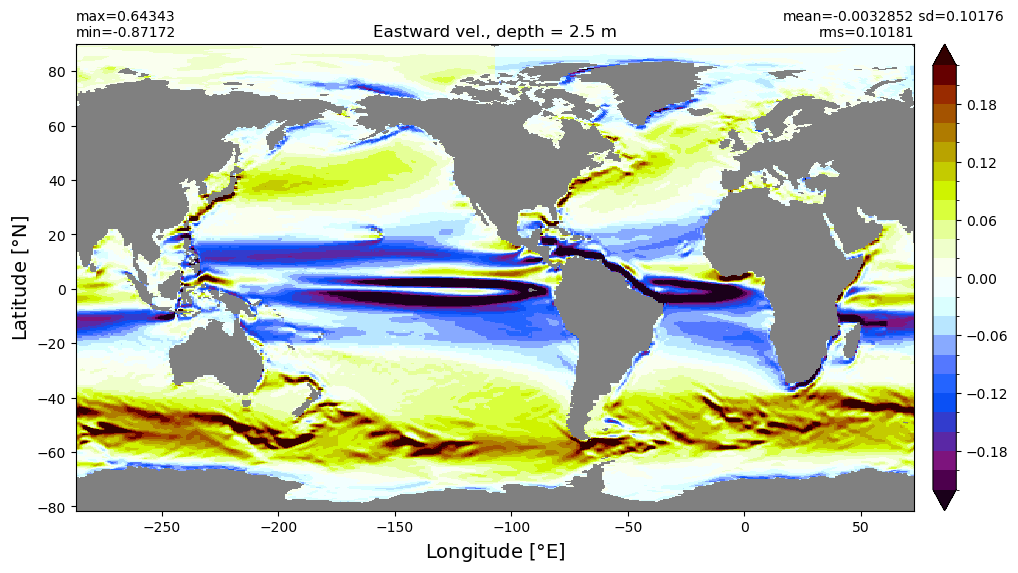

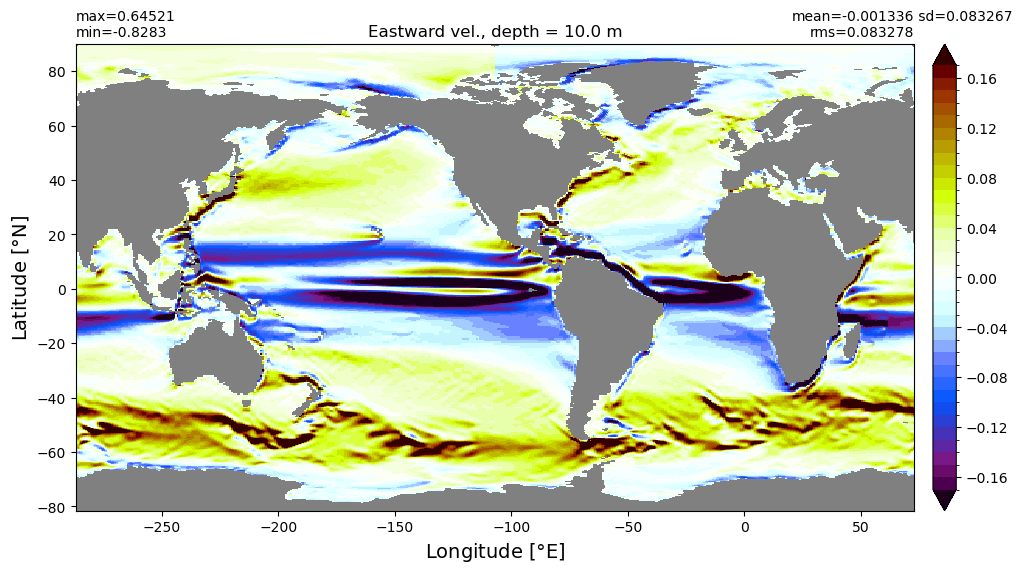

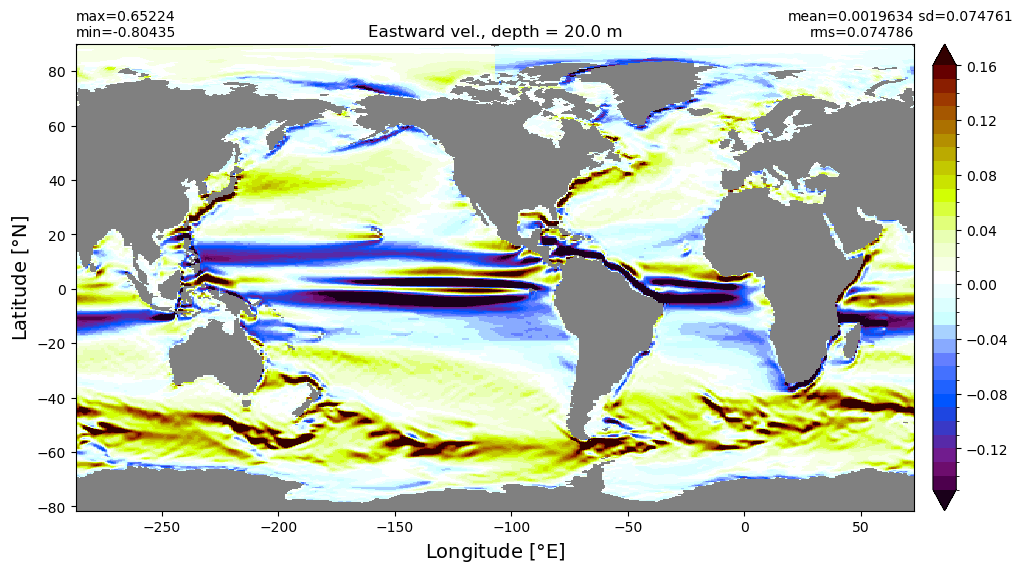

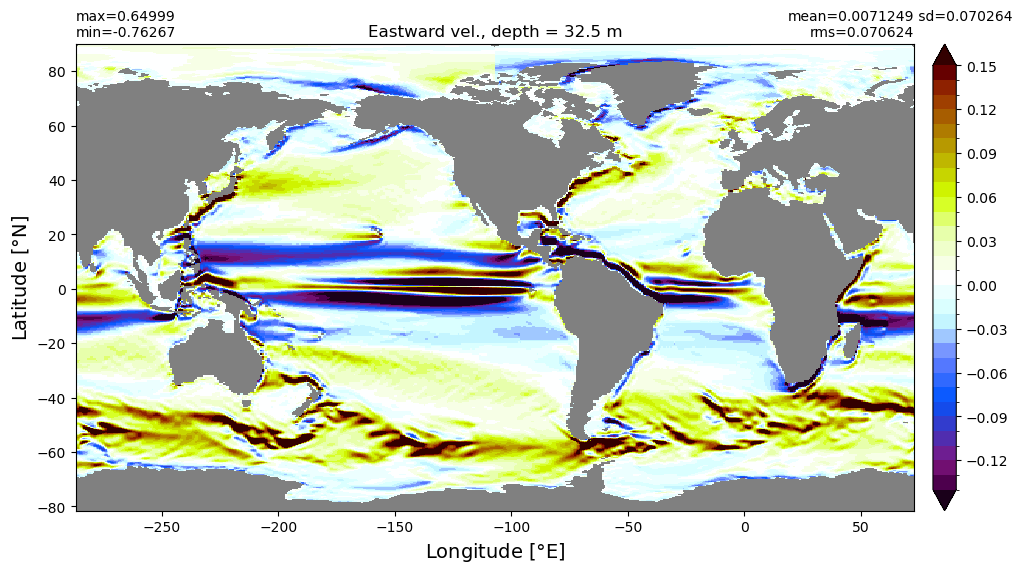

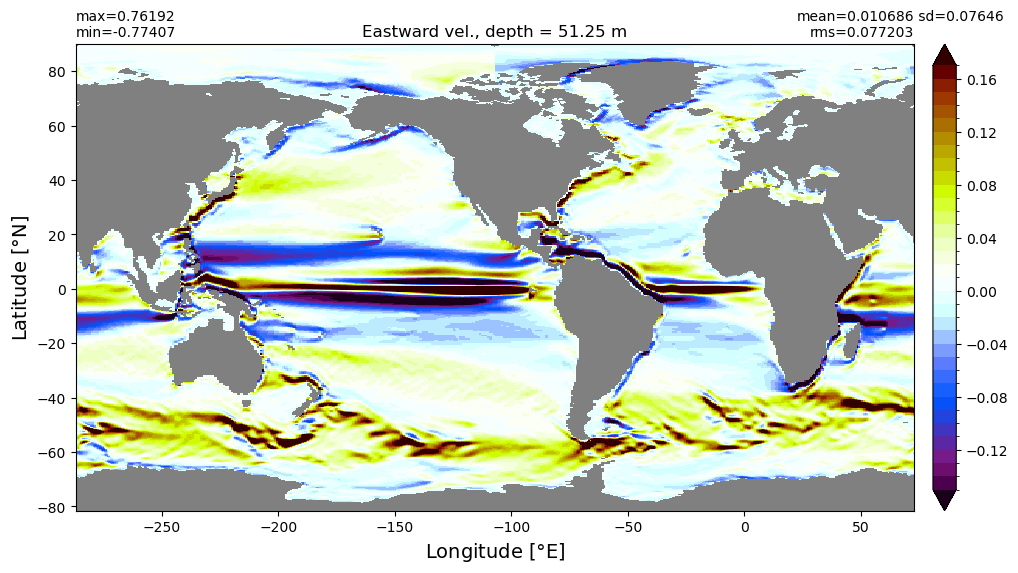

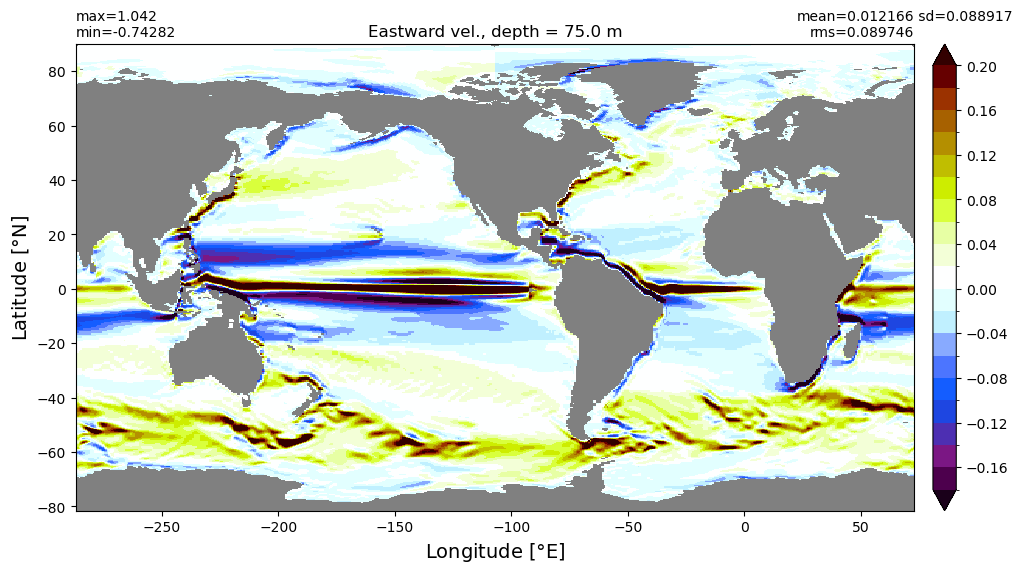

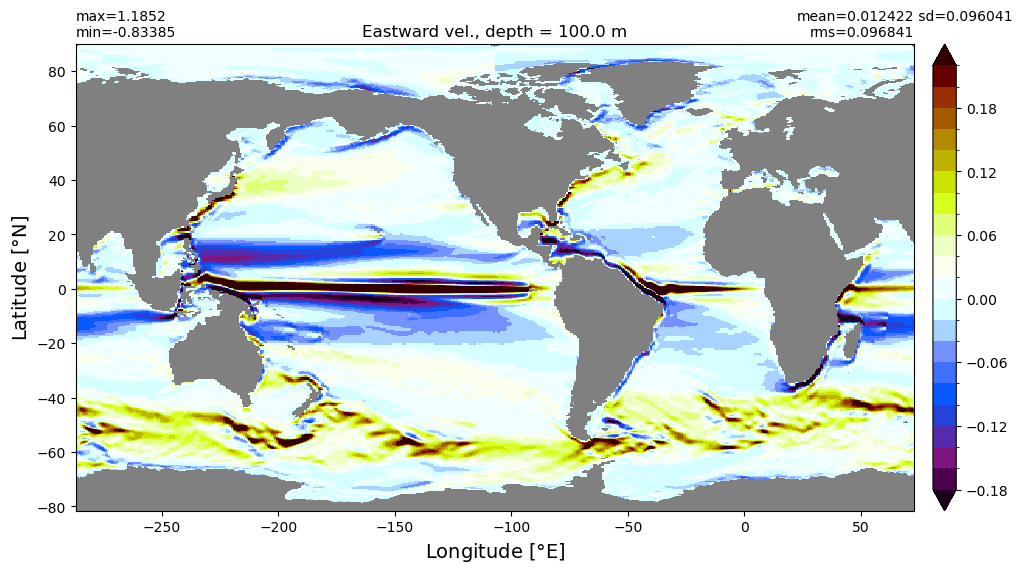

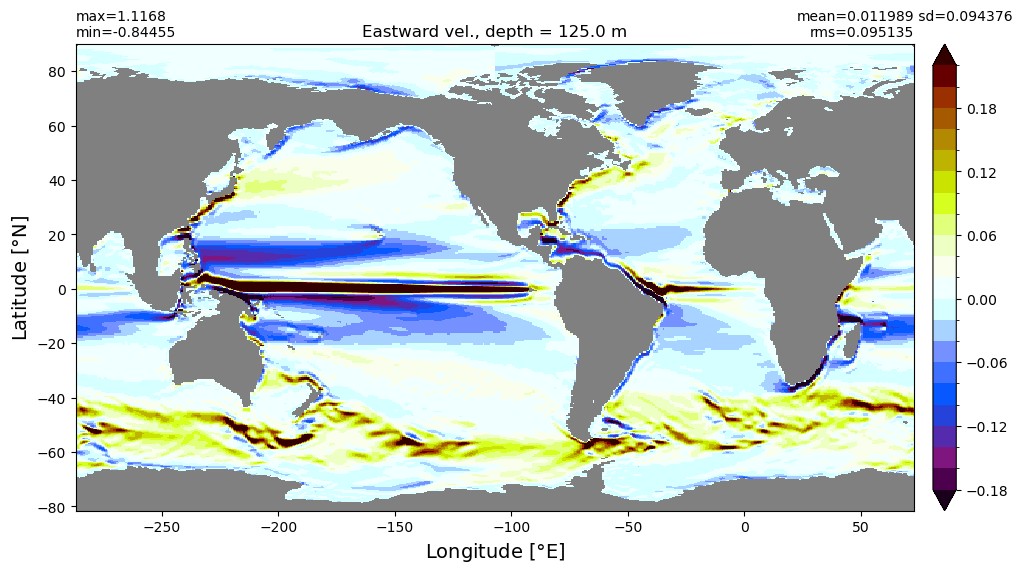

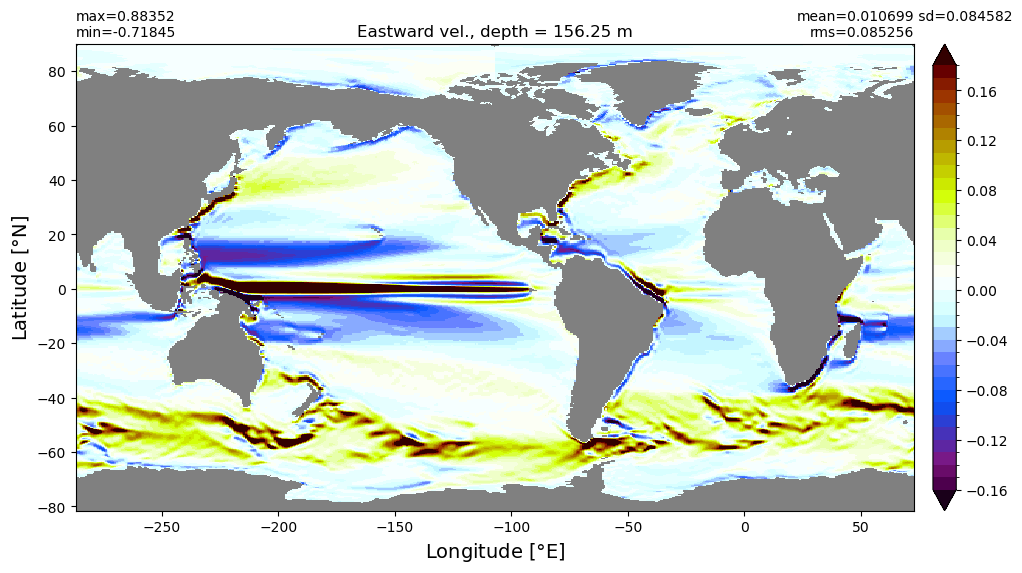

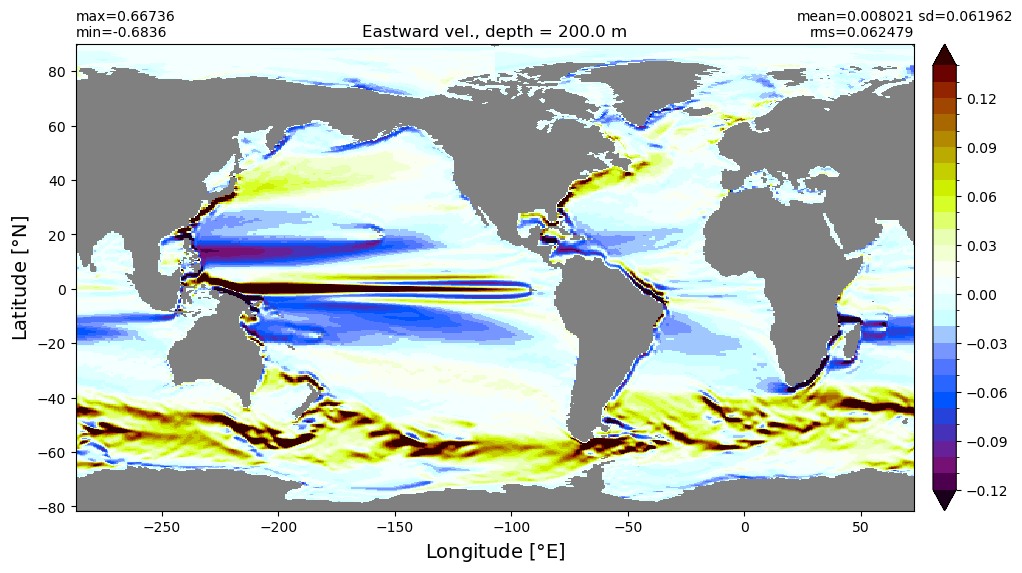

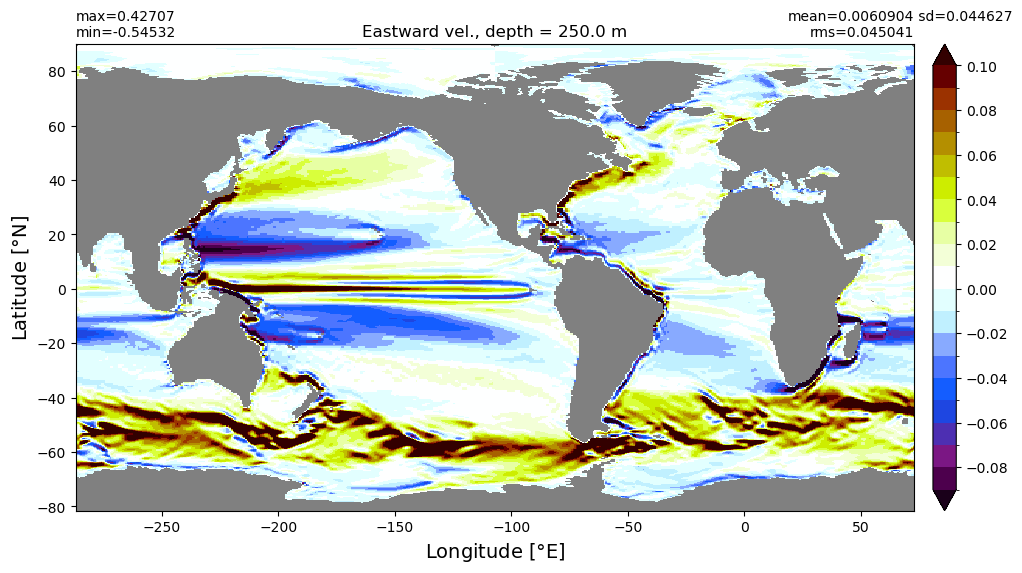

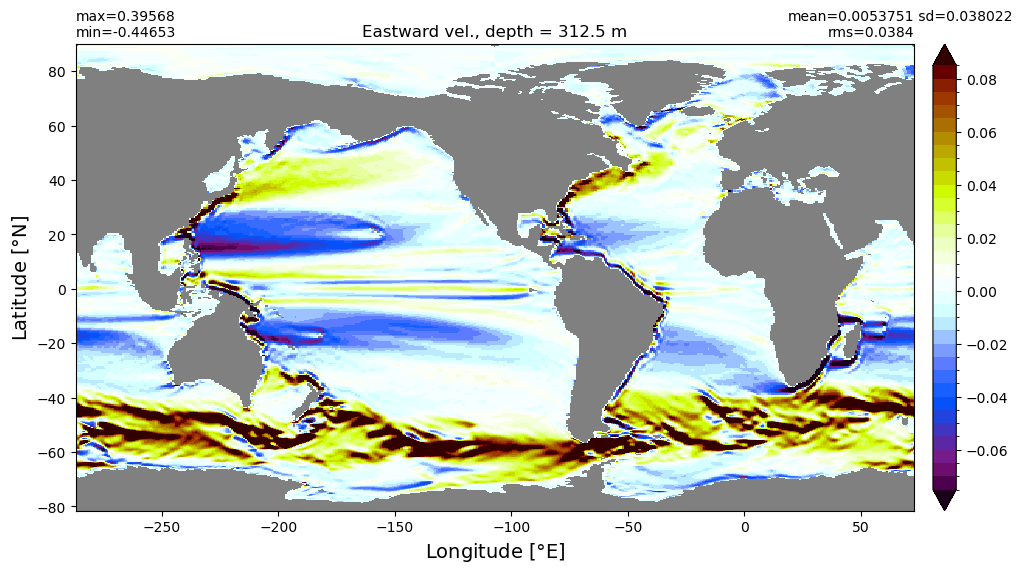

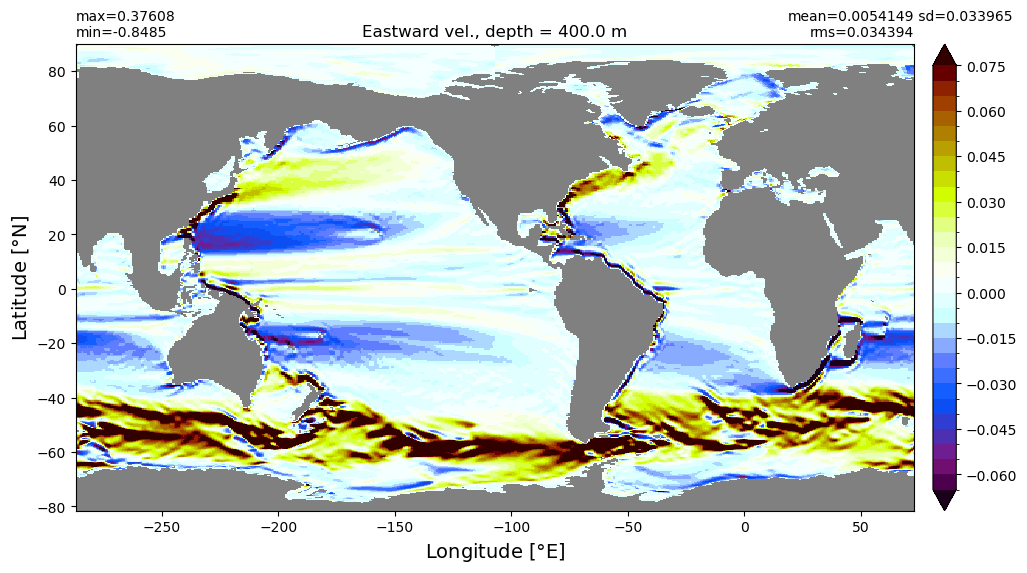

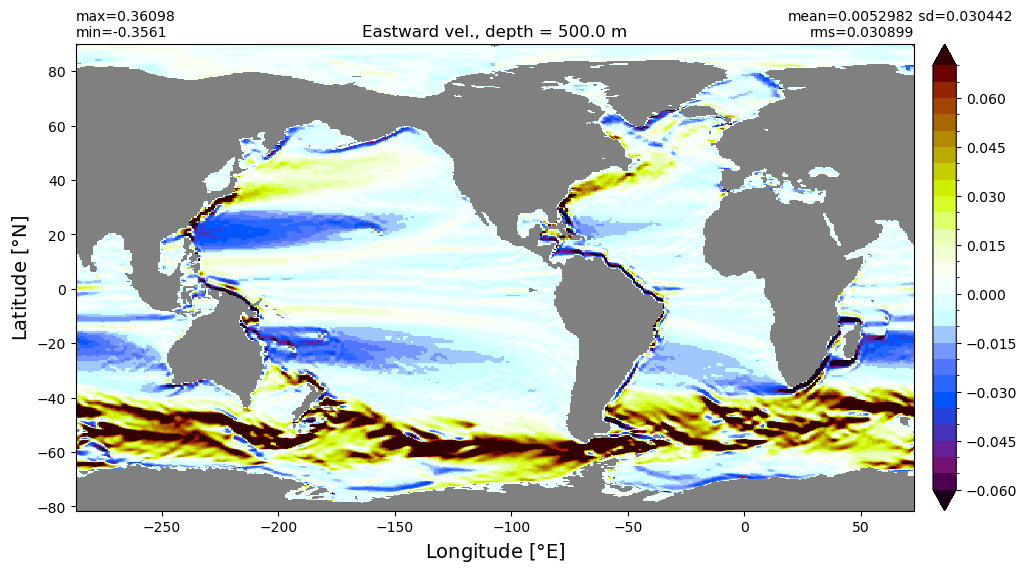

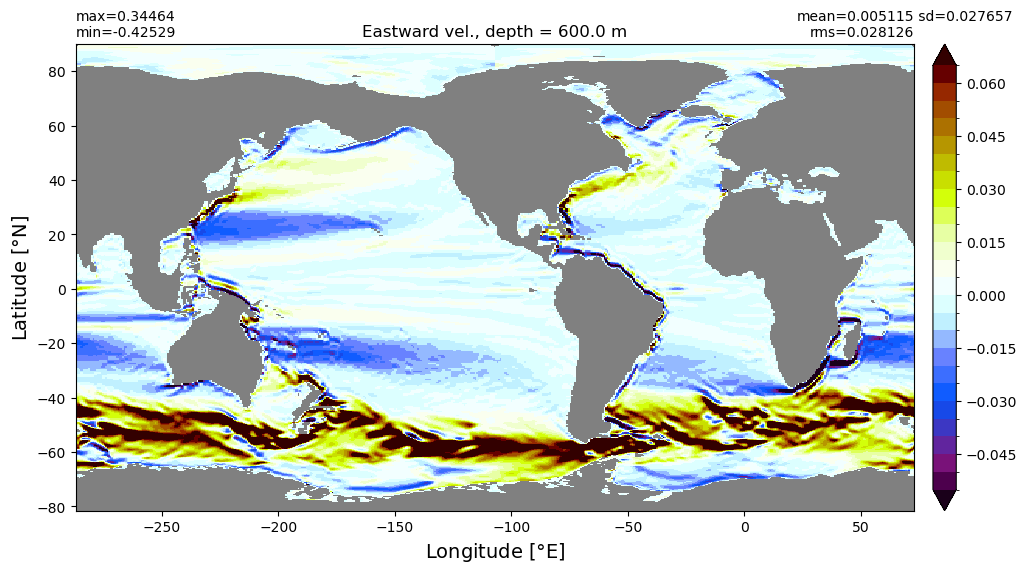

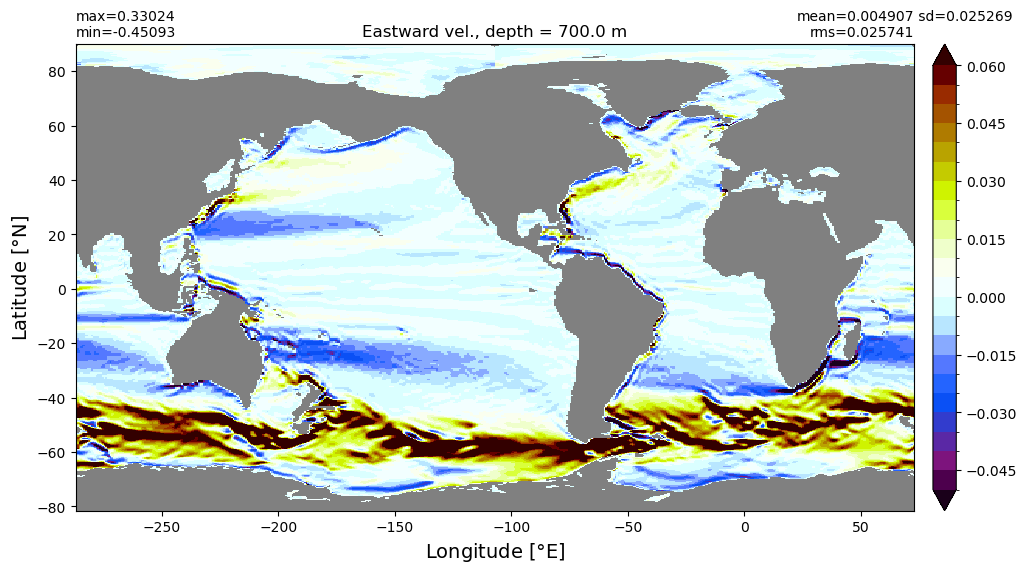

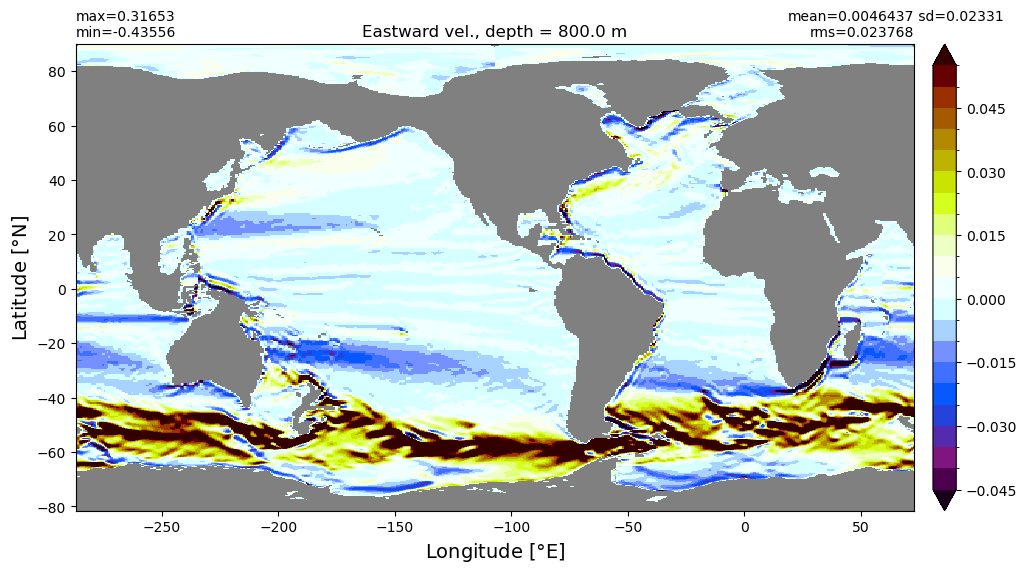

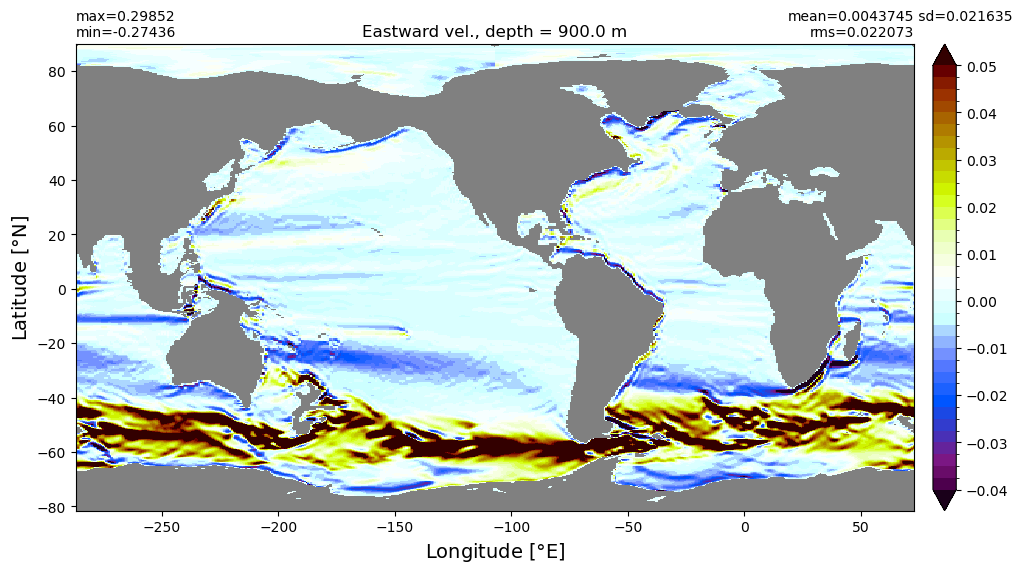

In [14]:
%matplotlib inline
# loop over depths 
km = uo.shape[0]
for k in range(km):
  # only shallower than 1000.0 m - this can be changed
  if ds_ann['z_l'][k].values < 1000.0:
    dummy = np.ma.masked_where(grd.wet_u == 0, uo[k,:])
    # warning: using approximate lat/lon
    xyplot(dummy,grd.geolon, grd.geolat, area=grd.areacello_cu,
          title = 'Eastward vel., depth = {} m'.format(str(ds_ann['z_l'][k].values)),
          extend='both',show= True)

### Meridional velocity

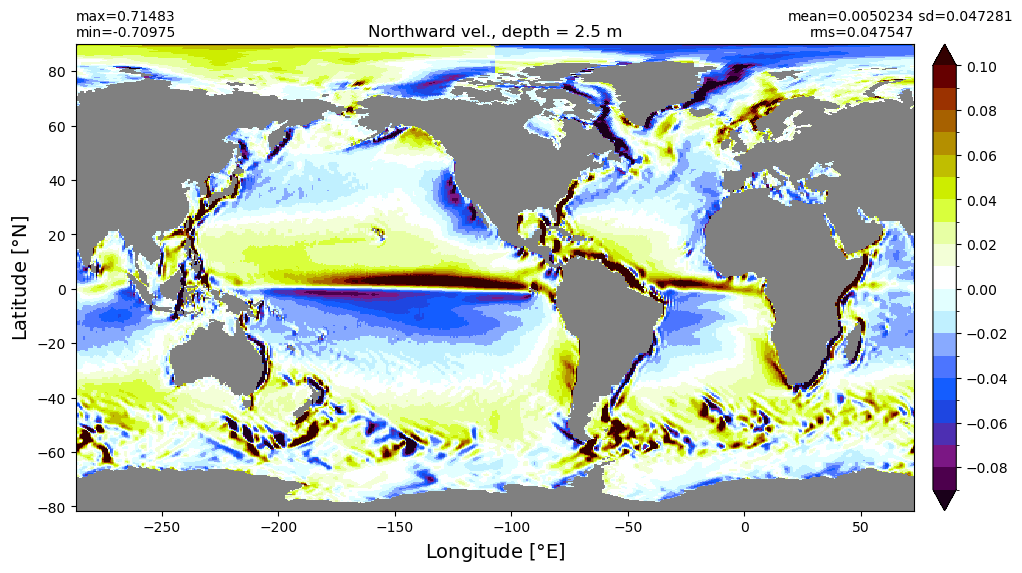

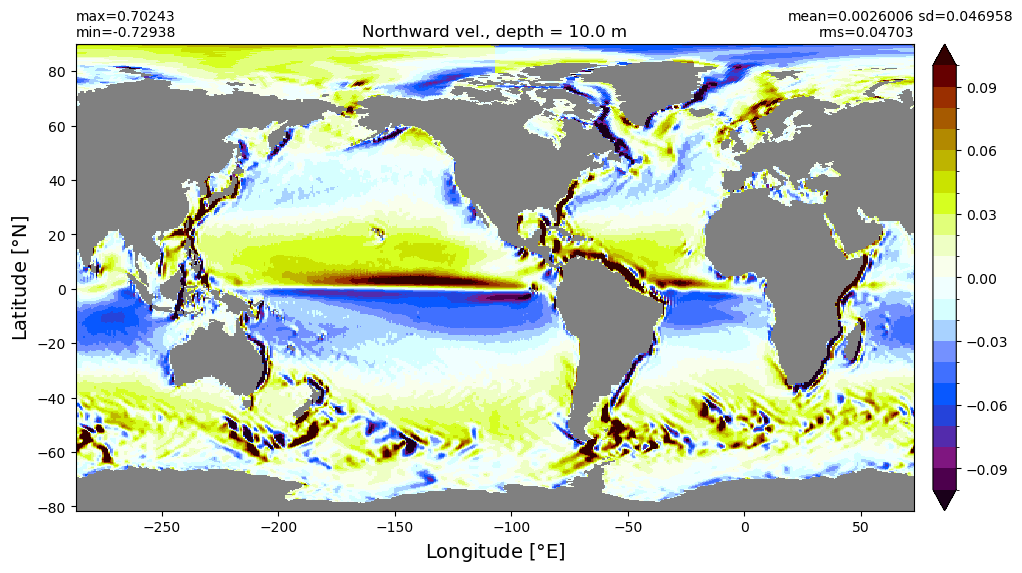

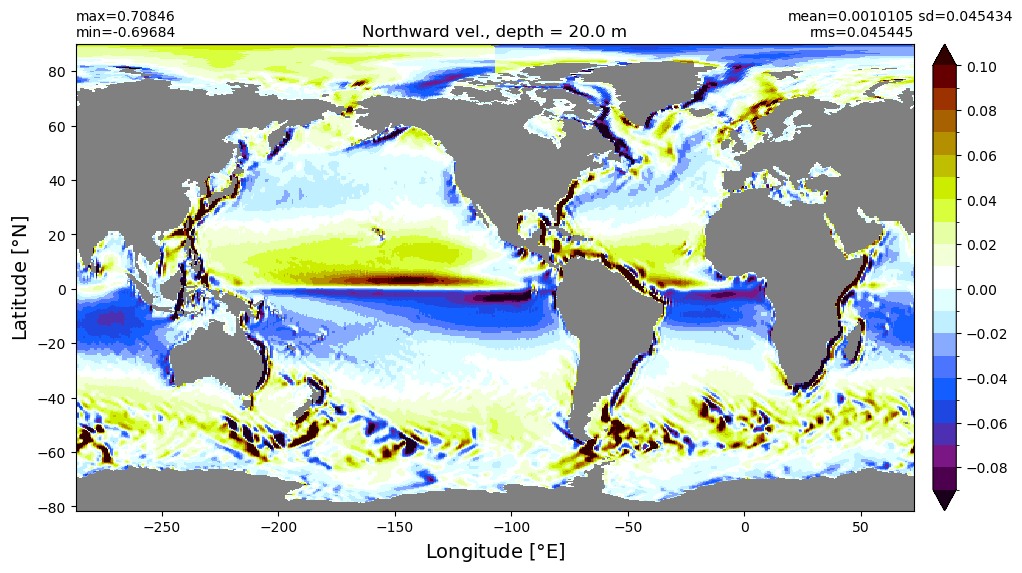

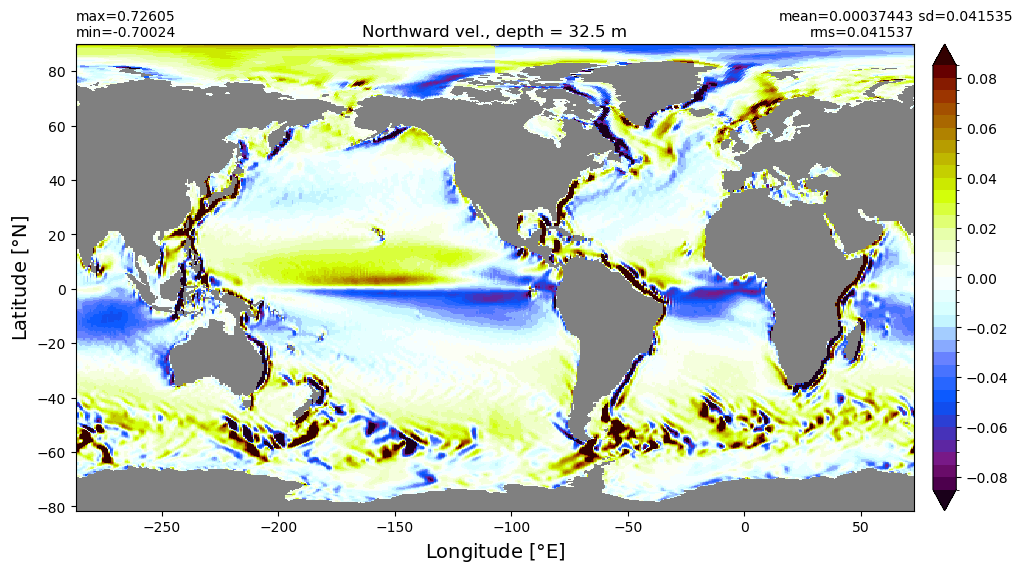

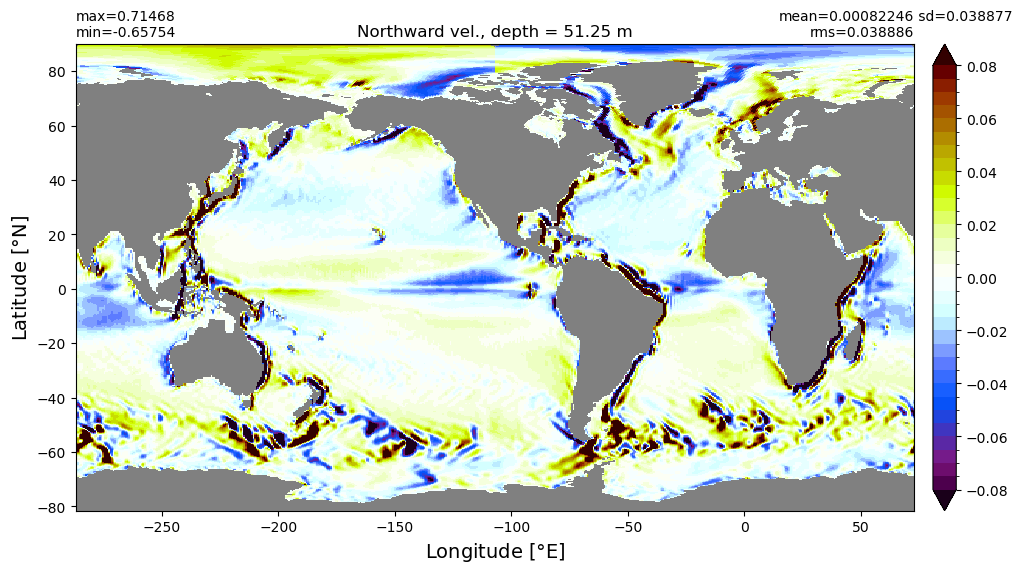

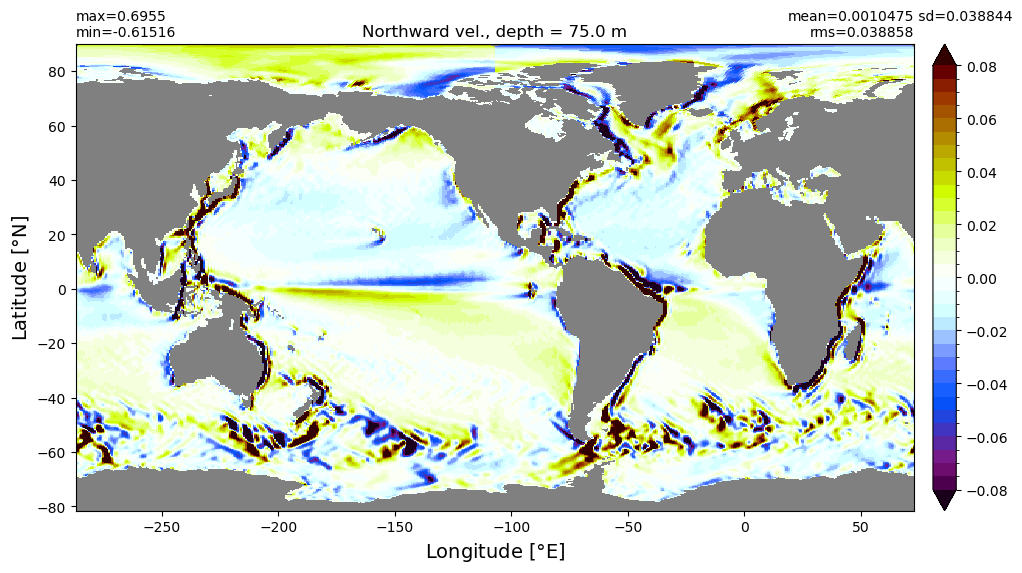

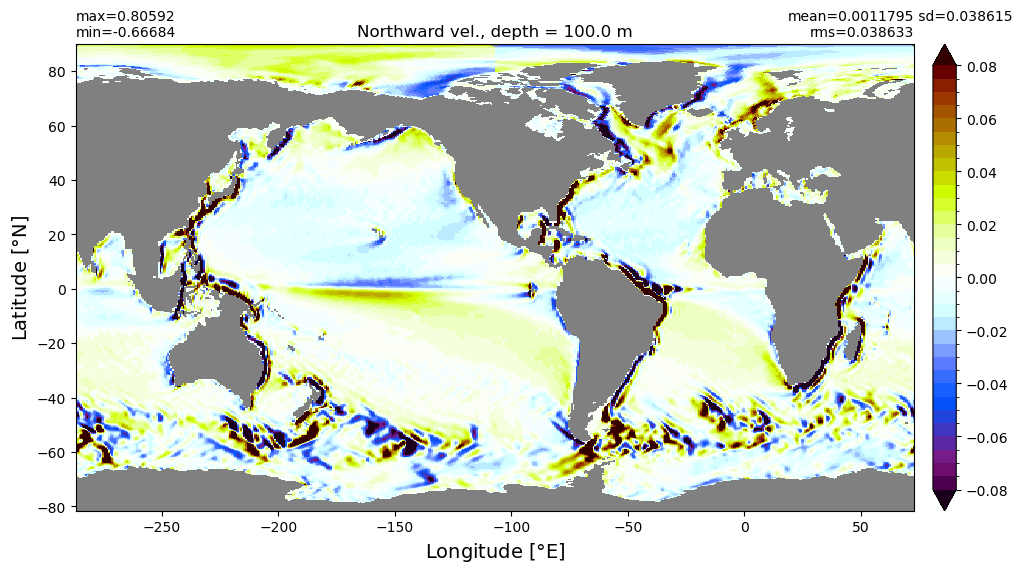

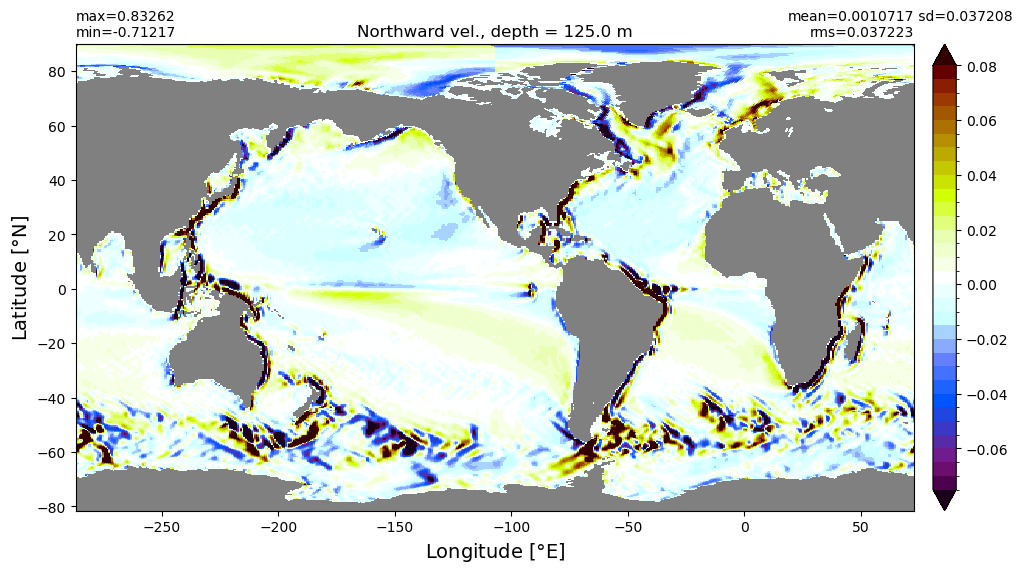

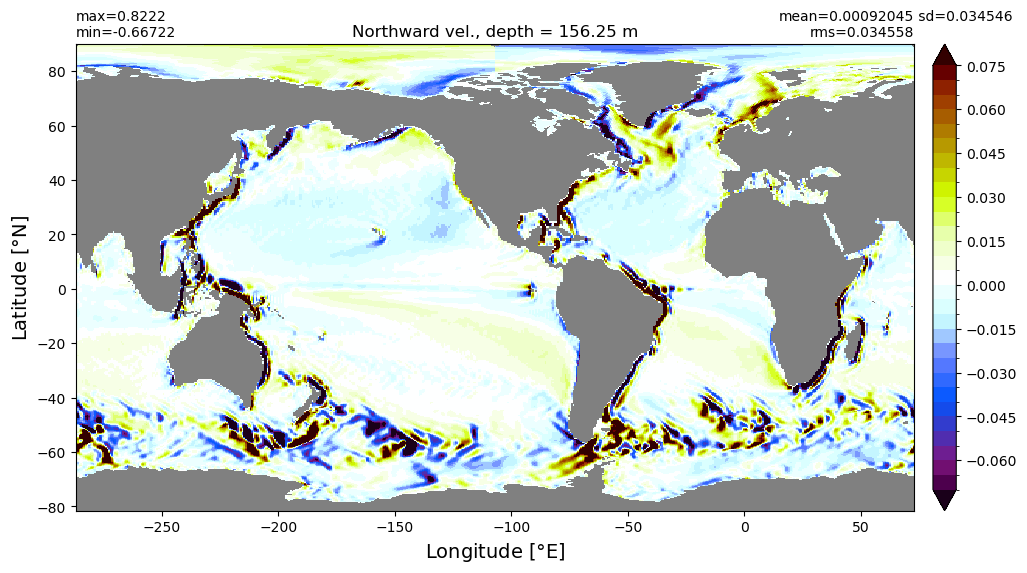

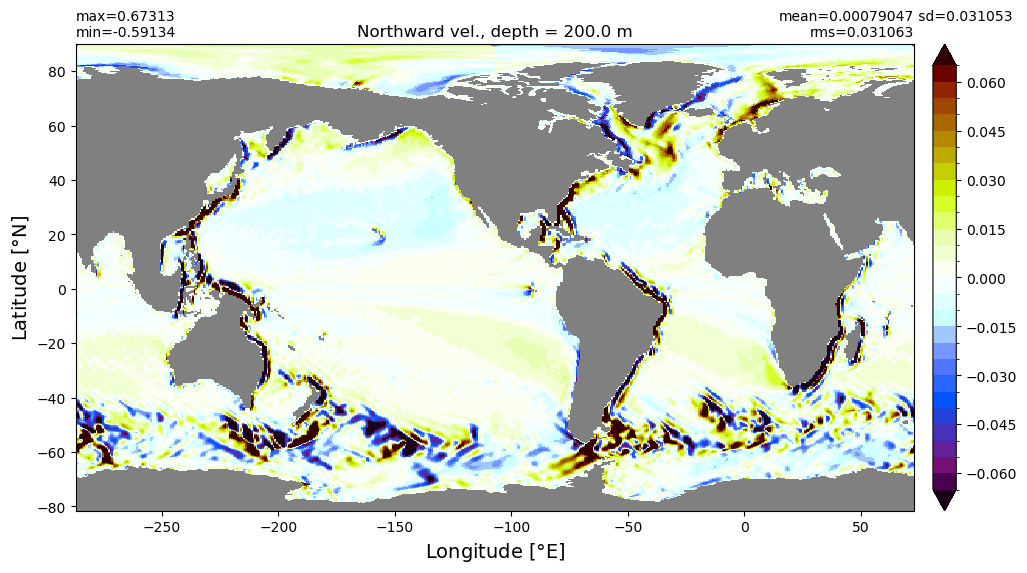

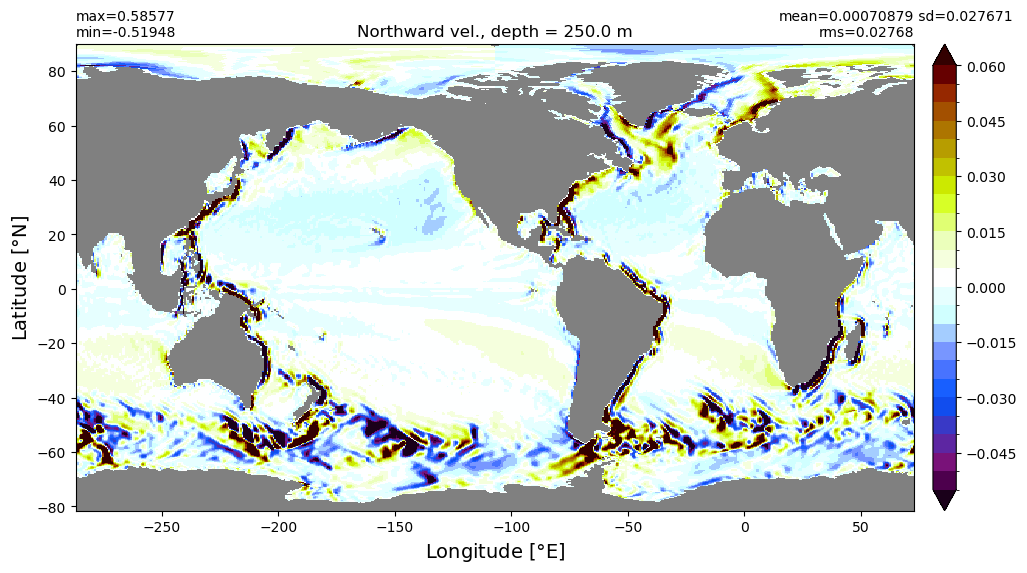

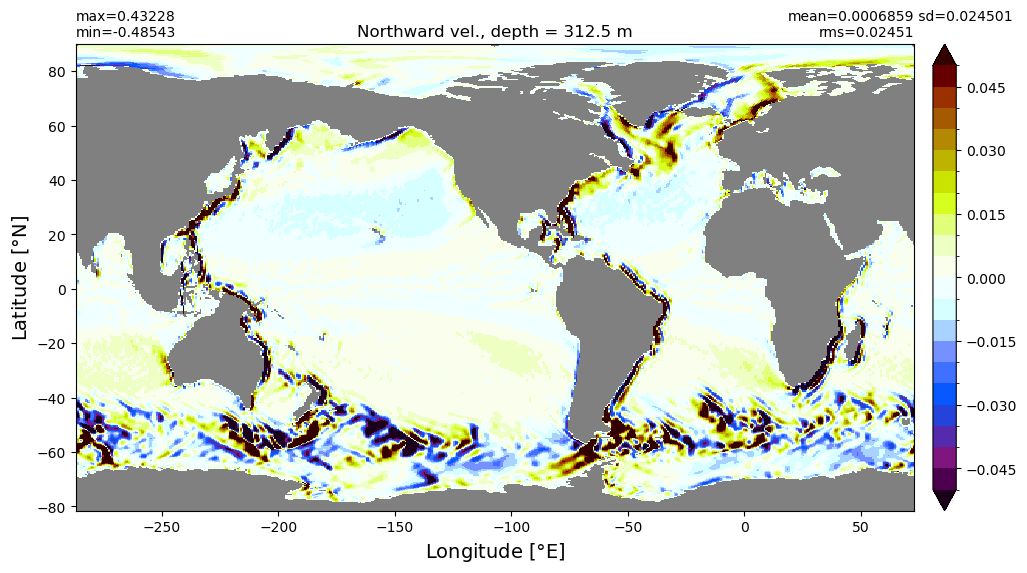

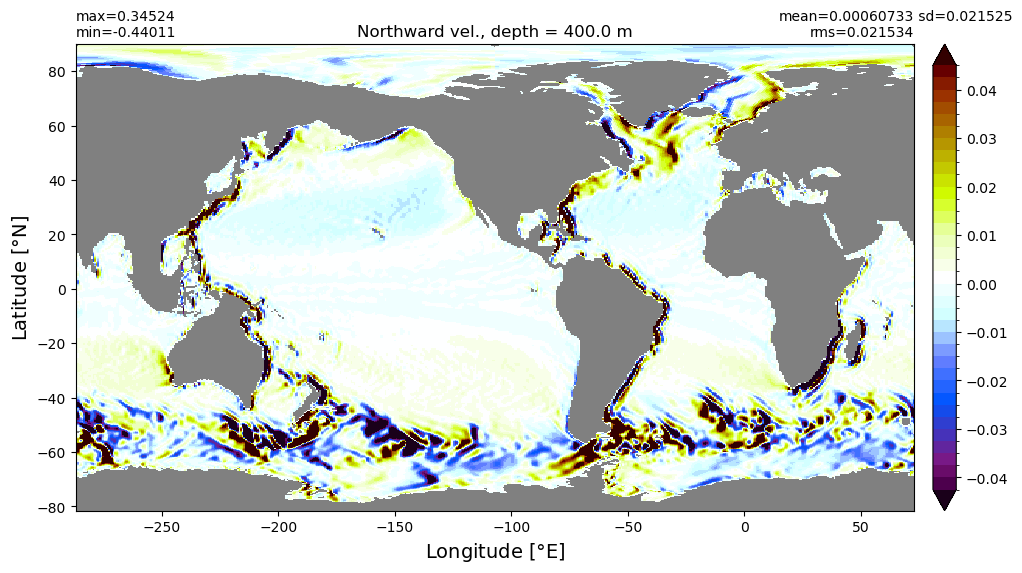

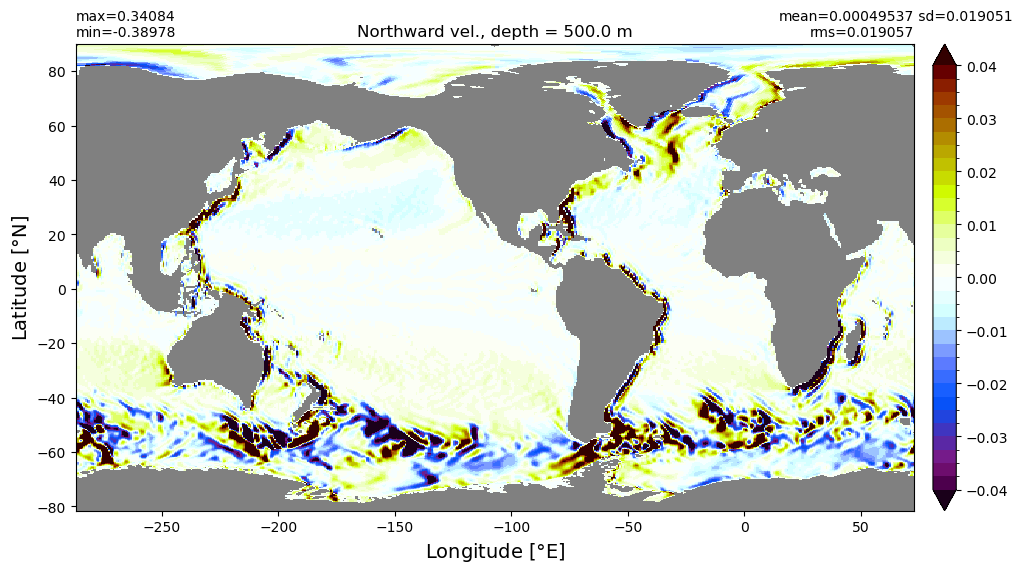

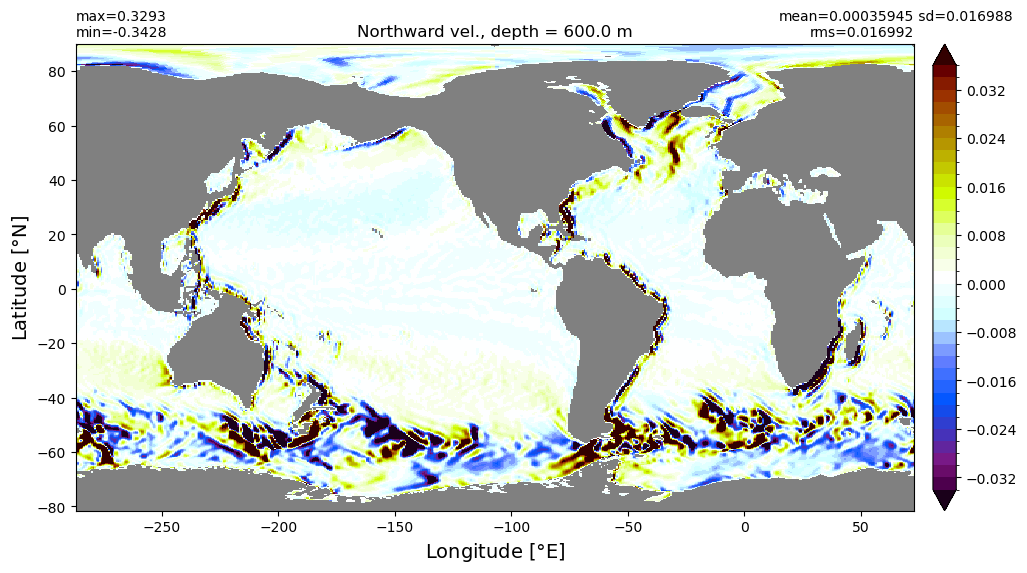

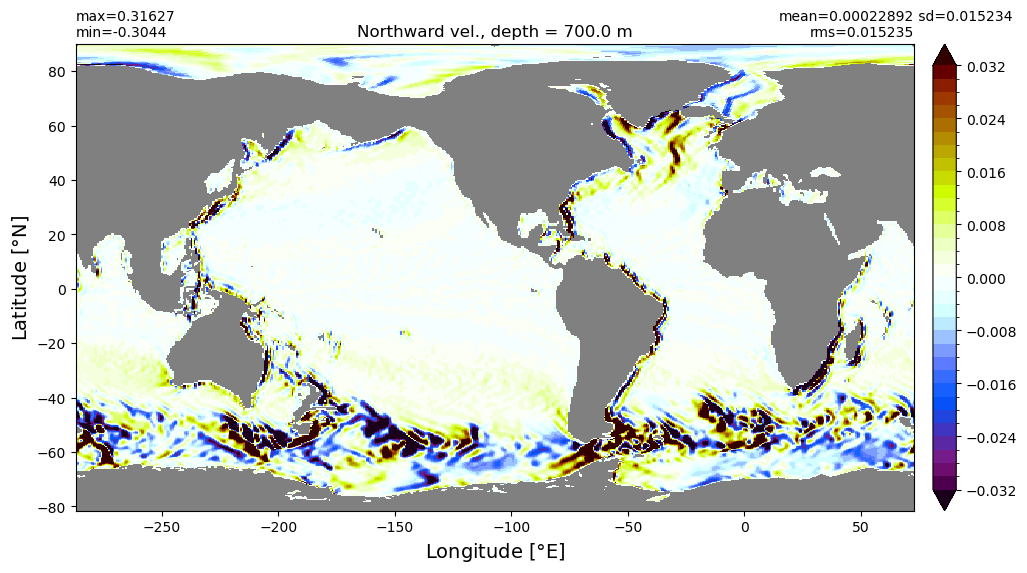

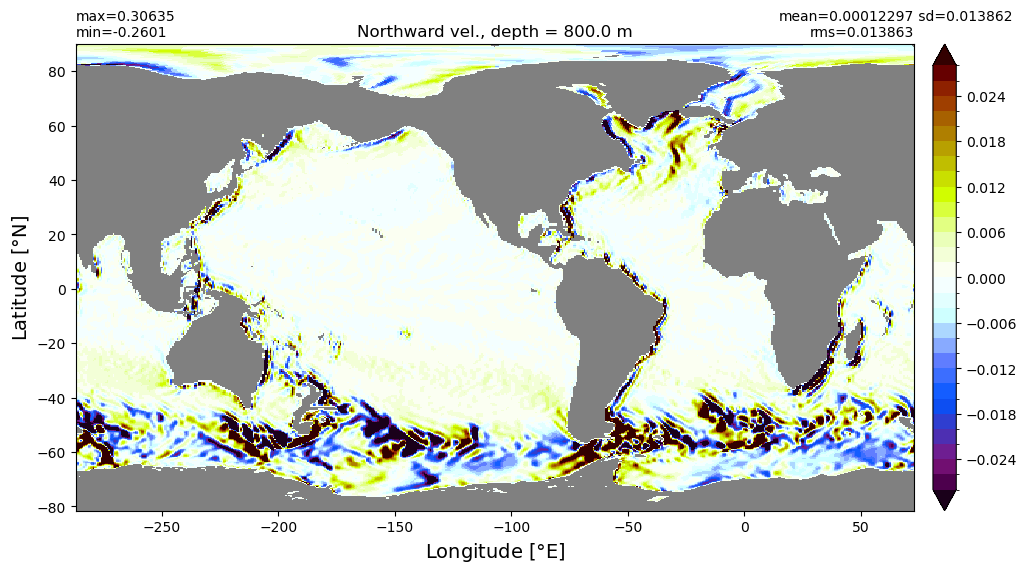

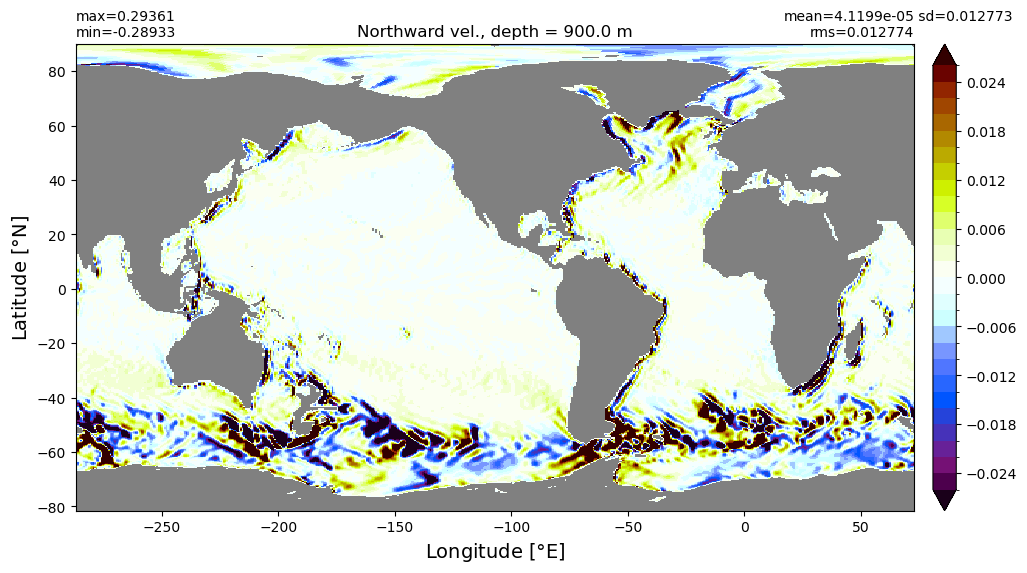

In [15]:
# loop over depths 
km = vo.shape[0]
for k in range(km):
  # only shallower than 1000.0 m - this can be changed
  if ds_ann['z_l'][k].values < 1000.0:
    dummy = np.ma.masked_where(grd.wet_v == 0, vo[k,:]) 
    # warning: using approximate lat/lon
    xyplot(dummy,grd.geolon, grd.geolat, area=grd.areacello_cv,
          title = 'Northward vel., depth = {} m'.format(str(ds_ann['z_l'][k].values)),
          extend='both',show= True)